In [101]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import LSTM

#from tensorflow.python.keras.layers import CuDNNLSTM
#from tensorflow.keras.models import Sequential

In [102]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [103]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df = pd.read_json(url_binance_bnbusdt_5m)

df.columns = [
    'time', 
    'open', 
    'high', 
    'low', 
    'close', 
    'volume', 
    'close_time', 
    'quote_asset_volume', 
    'number_of_trades', 
    'taker_buy_base_asset_volume', 
    'taker_buy_quote_asset_volume', 
    'unused'
]

df['date'] = pd.to_datetime(df['time'], unit='ms')

df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666514400000,269.7,269.8,269.7,269.8,439.634,1666514699999,118604.1910,287,349.012,94163.4376,0,2022-10-23 08:40:00
1,1666514700000,269.7,269.8,269.7,269.7,189.533,1666514999999,51123.6005,256,65.504,17672.9792,0,2022-10-23 08:45:00
2,1666515000000,269.7,270.1,269.7,270.1,1120.039,1666515299999,302312.2704,350,993.697,268203.3497,0,2022-10-23 08:50:00
3,1666515300000,270.0,270.2,270.0,270.2,243.707,1666515599999,65824.4898,351,149.646,40424.3255,0,2022-10-23 08:55:00
4,1666515600000,270.2,270.3,270.2,270.3,226.088,1666515899999,61104.4777,291,183.650,49637.7138,0,2022-10-23 09:00:00


In [104]:
df.sort_values('time', inplace=True)

In [105]:
df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666514400000,269.7,269.8,269.7,269.8,439.634,1666514699999,118604.1910,287,349.012,94163.4376,0,2022-10-23 08:40:00
1,1666514700000,269.7,269.8,269.7,269.7,189.533,1666514999999,51123.6005,256,65.504,17672.9792,0,2022-10-23 08:45:00
2,1666515000000,269.7,270.1,269.7,270.1,1120.039,1666515299999,302312.2704,350,993.697,268203.3497,0,2022-10-23 08:50:00
3,1666515300000,270.0,270.2,270.0,270.2,243.707,1666515599999,65824.4898,351,149.646,40424.3255,0,2022-10-23 08:55:00
4,1666515600000,270.2,270.3,270.2,270.3,226.088,1666515899999,61104.4777,291,183.650,49637.7138,0,2022-10-23 09:00:00


Text(0, 0.5, 'Close Price')

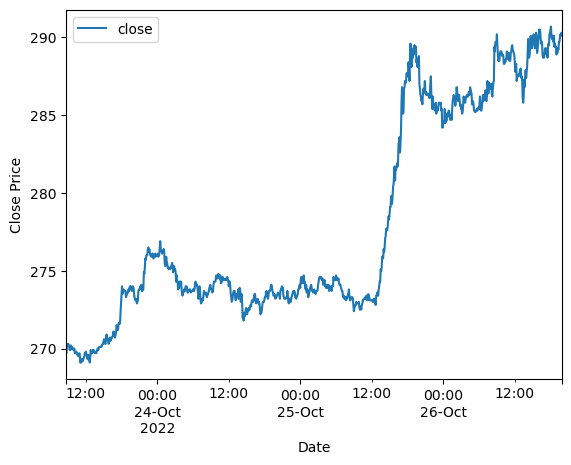

In [106]:
ax = df.plot(x='date', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")

## Normalization

In [107]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [108]:
scaled_close.shape

(1000, 1)

In [109]:
np.isnan(scaled_close).any()

False

In [110]:
scaled_close[:10], close_price[:10]

(array([[0.03240741],
        [0.02777778],
        [0.0462963 ],
        [0.05092593],
        [0.05555556],
        [0.05555556],
        [0.05092593],
        [0.04166667],
        [0.03703704],
        [0.03703704]]),
 array([[269.8],
        [269.7],
        [270.1],
        [270.2],
        [270.3],
        [270.3],
        [270.2],
        [270. ],
        [269.9],
        [269.9]]))

In [111]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [112]:
scaled_close = scaled_close.reshape(-1, 1)

In [113]:
np.isnan(scaled_close).any()

False

## Preprocessing

In [140]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.80)

In [141]:
X_train.shape

(720, 99, 1)

In [142]:
X_test.shape

(180, 99, 1)

## Model

In [143]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(tf.keras.layers.Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

## Training

In [144]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
11/11 [==============================] - 9s 374ms/step - loss: 0.0396 - val_loss: 0.0517
Epoch 2/50
11/11 [==============================] - 3s 278ms/step - loss: 0.0540 - val_loss: 0.0109
Epoch 3/50
11/11 [==============================] - 3s 278ms/step - loss: 0.0230 - val_loss: 0.0823
Epoch 4/50
11/11 [==============================] - 3s 278ms/step - loss: 0.0449 - val_loss: 0.0118
Epoch 5/50
11/11 [==============================] - 3s 278ms/step - loss: 0.0572 - val_loss: 0.0409
Epoch 6/50
11/11 [==============================] - 3s 281ms/step - loss: 0.0238 - val_loss: 0.0021
Epoch 7/50
11/11 [==============================] - 3s 276ms/step - loss: 0.0412 - val_loss: 0.1844
Epoch 8/50
11/11 [==============================] - 3s 277ms/step - loss: 0.0129 - val_loss: 0.0274
Epoch 9/50
11/11 [==============================] - 3s 277ms/step - loss: 0.0172 - val_loss: 0.0086
Epoch 10/50
11/11 [==============================] - 3s 278ms/step - loss: 0.0057 - val_loss: 0.0016

In [137]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 40ms/step - loss: 0.2799


0.2798733711242676

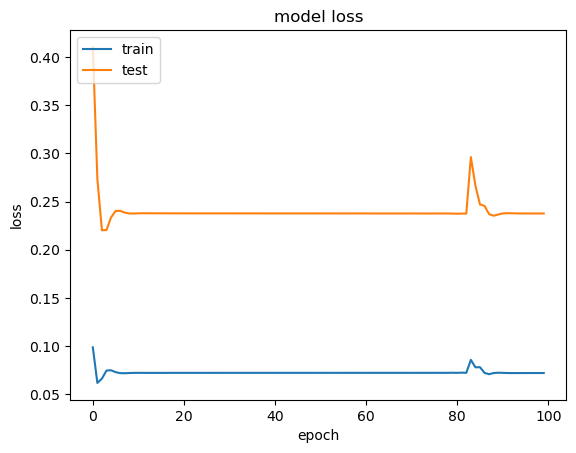

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

2/2 [==============================] - 1s 40ms/step


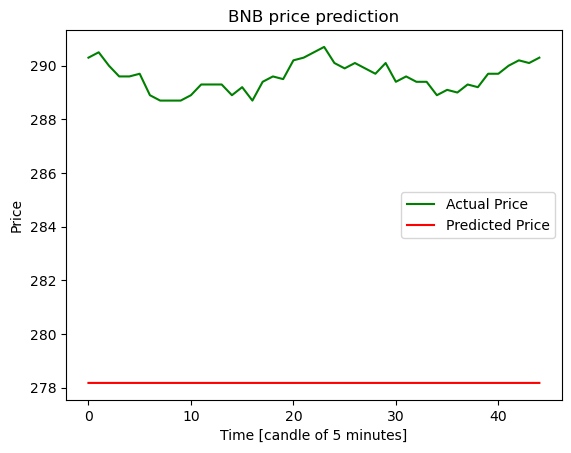

In [139]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('BNB price prediction')
plt.xlabel('Time [candle of 5 minutes]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();